In [7]:
from Samplers.sampler_test import *
from Samplers.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv')
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']].dropna()


In [8]:
mean_bmi = bmi_sbp_data['bmi'].mean()
mean_sbp = bmi_sbp_data['sbp'].mean()
std_bmi = bmi_sbp_data['bmi'].std()
std_sbp = bmi_sbp_data['sbp'].std()
bmi_sbp_data.loc[:, 'bmi'] = (bmi_sbp_data['bmi'] - mean_bmi) / std_bmi
bmi_sbp_data.loc[:, 'sbp'] = (bmi_sbp_data['sbp'] - mean_sbp) / std_sbp
bmi_bounds = (np.array([18, 25, 30, np.inf])-mean_bmi)/std_bmi
sbp_bounds = (np.array([140, 160, np.inf])-mean_sbp)/std_sbp

corners = np.array([
    [bmi_bounds[0] - 0.05, sbp_bounds[0] - 0.05],
    [bmi_bounds[2] + 0.05, sbp_bounds[0] - 0.05],
    [bmi_bounds[0] - 0.05, sbp_bounds[1] + 0.05],
    [bmi_bounds[2] - 0.05, sbp_bounds[1] + 0.05]
])
corners


array([[-1.64292516,  0.89215523],
       [ 0.06717543,  0.89215523],
       [-1.64292516,  2.09056188],
       [-0.03282457,  2.09056188]])

In [9]:
from scipy.spatial.distance import pdist

def h1(mu):
    return np.min(pdist(mu))

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0



Running for N = 500


Sampling: 100%|██████████| 2000/2000 [00:09<00:00, 220.60it/s]



Running for N = 1000


Sampling: 100%|██████████| 2000/2000 [00:14<00:00, 133.82it/s]



Running for N = 2000


Sampling: 100%|██████████| 2000/2000 [00:25<00:00, 78.55it/s]



Running for N = 3000


Sampling: 100%|██████████| 2000/2000 [00:37<00:00, 53.83it/s]



Running for N = 5000


Sampling: 100%|██████████| 2000/2000 [00:58<00:00, 34.12it/s]



Running for N = 8000


Sampling: 100%|██████████| 2000/2000 [01:35<00:00, 20.91it/s]



Running for N = 10322


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.20it/s]


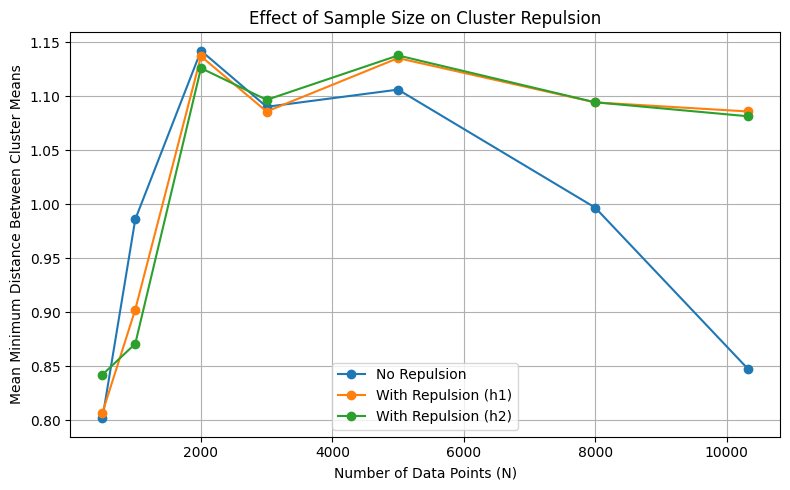

In [10]:
from Samplers.functions import *

# --- Distance Metric Function ---
def mu_distance(mu_samples, mode='min'):
    trace = []
    for mu in mu_samples:
        dists = pdist(mu)
        if mode == 'min':
            trace.append(np.min(dists))
        elif mode == 'mean':
            trace.append(np.mean(dists))
        elif mode == 'max':
            trace.append(np.max(dists))
        else:
            raise ValueError("mode must be 'min', 'mean', or 'max'")
    return np.mean(trace)  # aggregate over iterations


# --- Experiment Setup ---
K = 4
num_iterations = 2000
burn_in = 500
sig = 0.1
all_N = [500,1000, 2000, 3000, 5000,8000,10322]

repulsion_noh = []
repulsion_withh1 = []
repulsion_withh2 = []

for N in all_N:
    print(f"\nRunning for N = {N}")
    # Randomly sample N rows from the NumPy array
    np.random.seed(42)  # Ensure reproducibility
    indices = np.random.choice(bmi_sbp_data.shape[0], size=N, replace=False)
    X_subset = bmi_sbp_data.iloc[indices]
    
    # --- Gibbs Sampler (no repulsion) ---
    samples_noh = gibbs_sampler_gmm_multivariate(X_subset, K, num_iterations, burn_in)
    mu_noh = np.array([s[1] for s in samples_noh])
    repulsion_noh.append(mu_distance(mu_noh, mode='min'))

    # --- Gibbs with Repulsion (h1) ---
    samples_withh1 = bayesian_repulsive_randomwalk(X_subset, K, num_iterations, h1, burn_in, sig, mu=corners)
    mu_withh1 = np.array([s[1] for s in samples_withh1])
    repulsion_withh1.append(mu_distance(mu_withh1, mode='min'))
    # --- Gibbs with Repulsion (h2) ---
    samples_withh2 = bayesian_repulsive_randomwalk(X_subset, K, num_iterations, h2, burn_in, sig, mu=corners)
    mu_withh2 = np.array([s[1] for s in samples_withh2])
    repulsion_withh2.append(mu_distance(mu_withh2, mode='min'))

# --- Plot Results ---
plt.figure(figsize=(8, 5))
plt.plot(all_N, repulsion_noh, label='No Repulsion', marker='o')
plt.plot(all_N, repulsion_withh1, label='With Repulsion (h1)', marker='o')
plt.plot(all_N, repulsion_withh2, label='With Repulsion (h2)', marker='o')
plt.xlabel('Number of Data Points (N)')
plt.ylabel('Mean Minimum Distance Between Cluster Means')
plt.title('Effect of Sample Size on Cluster Repulsion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Running Gibbs Sampler for sigma = 0.06


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.25it/s]


Running Gibbs Sampler for sigma = 0.065


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.13it/s]


Running Gibbs Sampler for sigma = 0.07


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.18it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 2000/2000 [02:05<00:00, 15.97it/s]


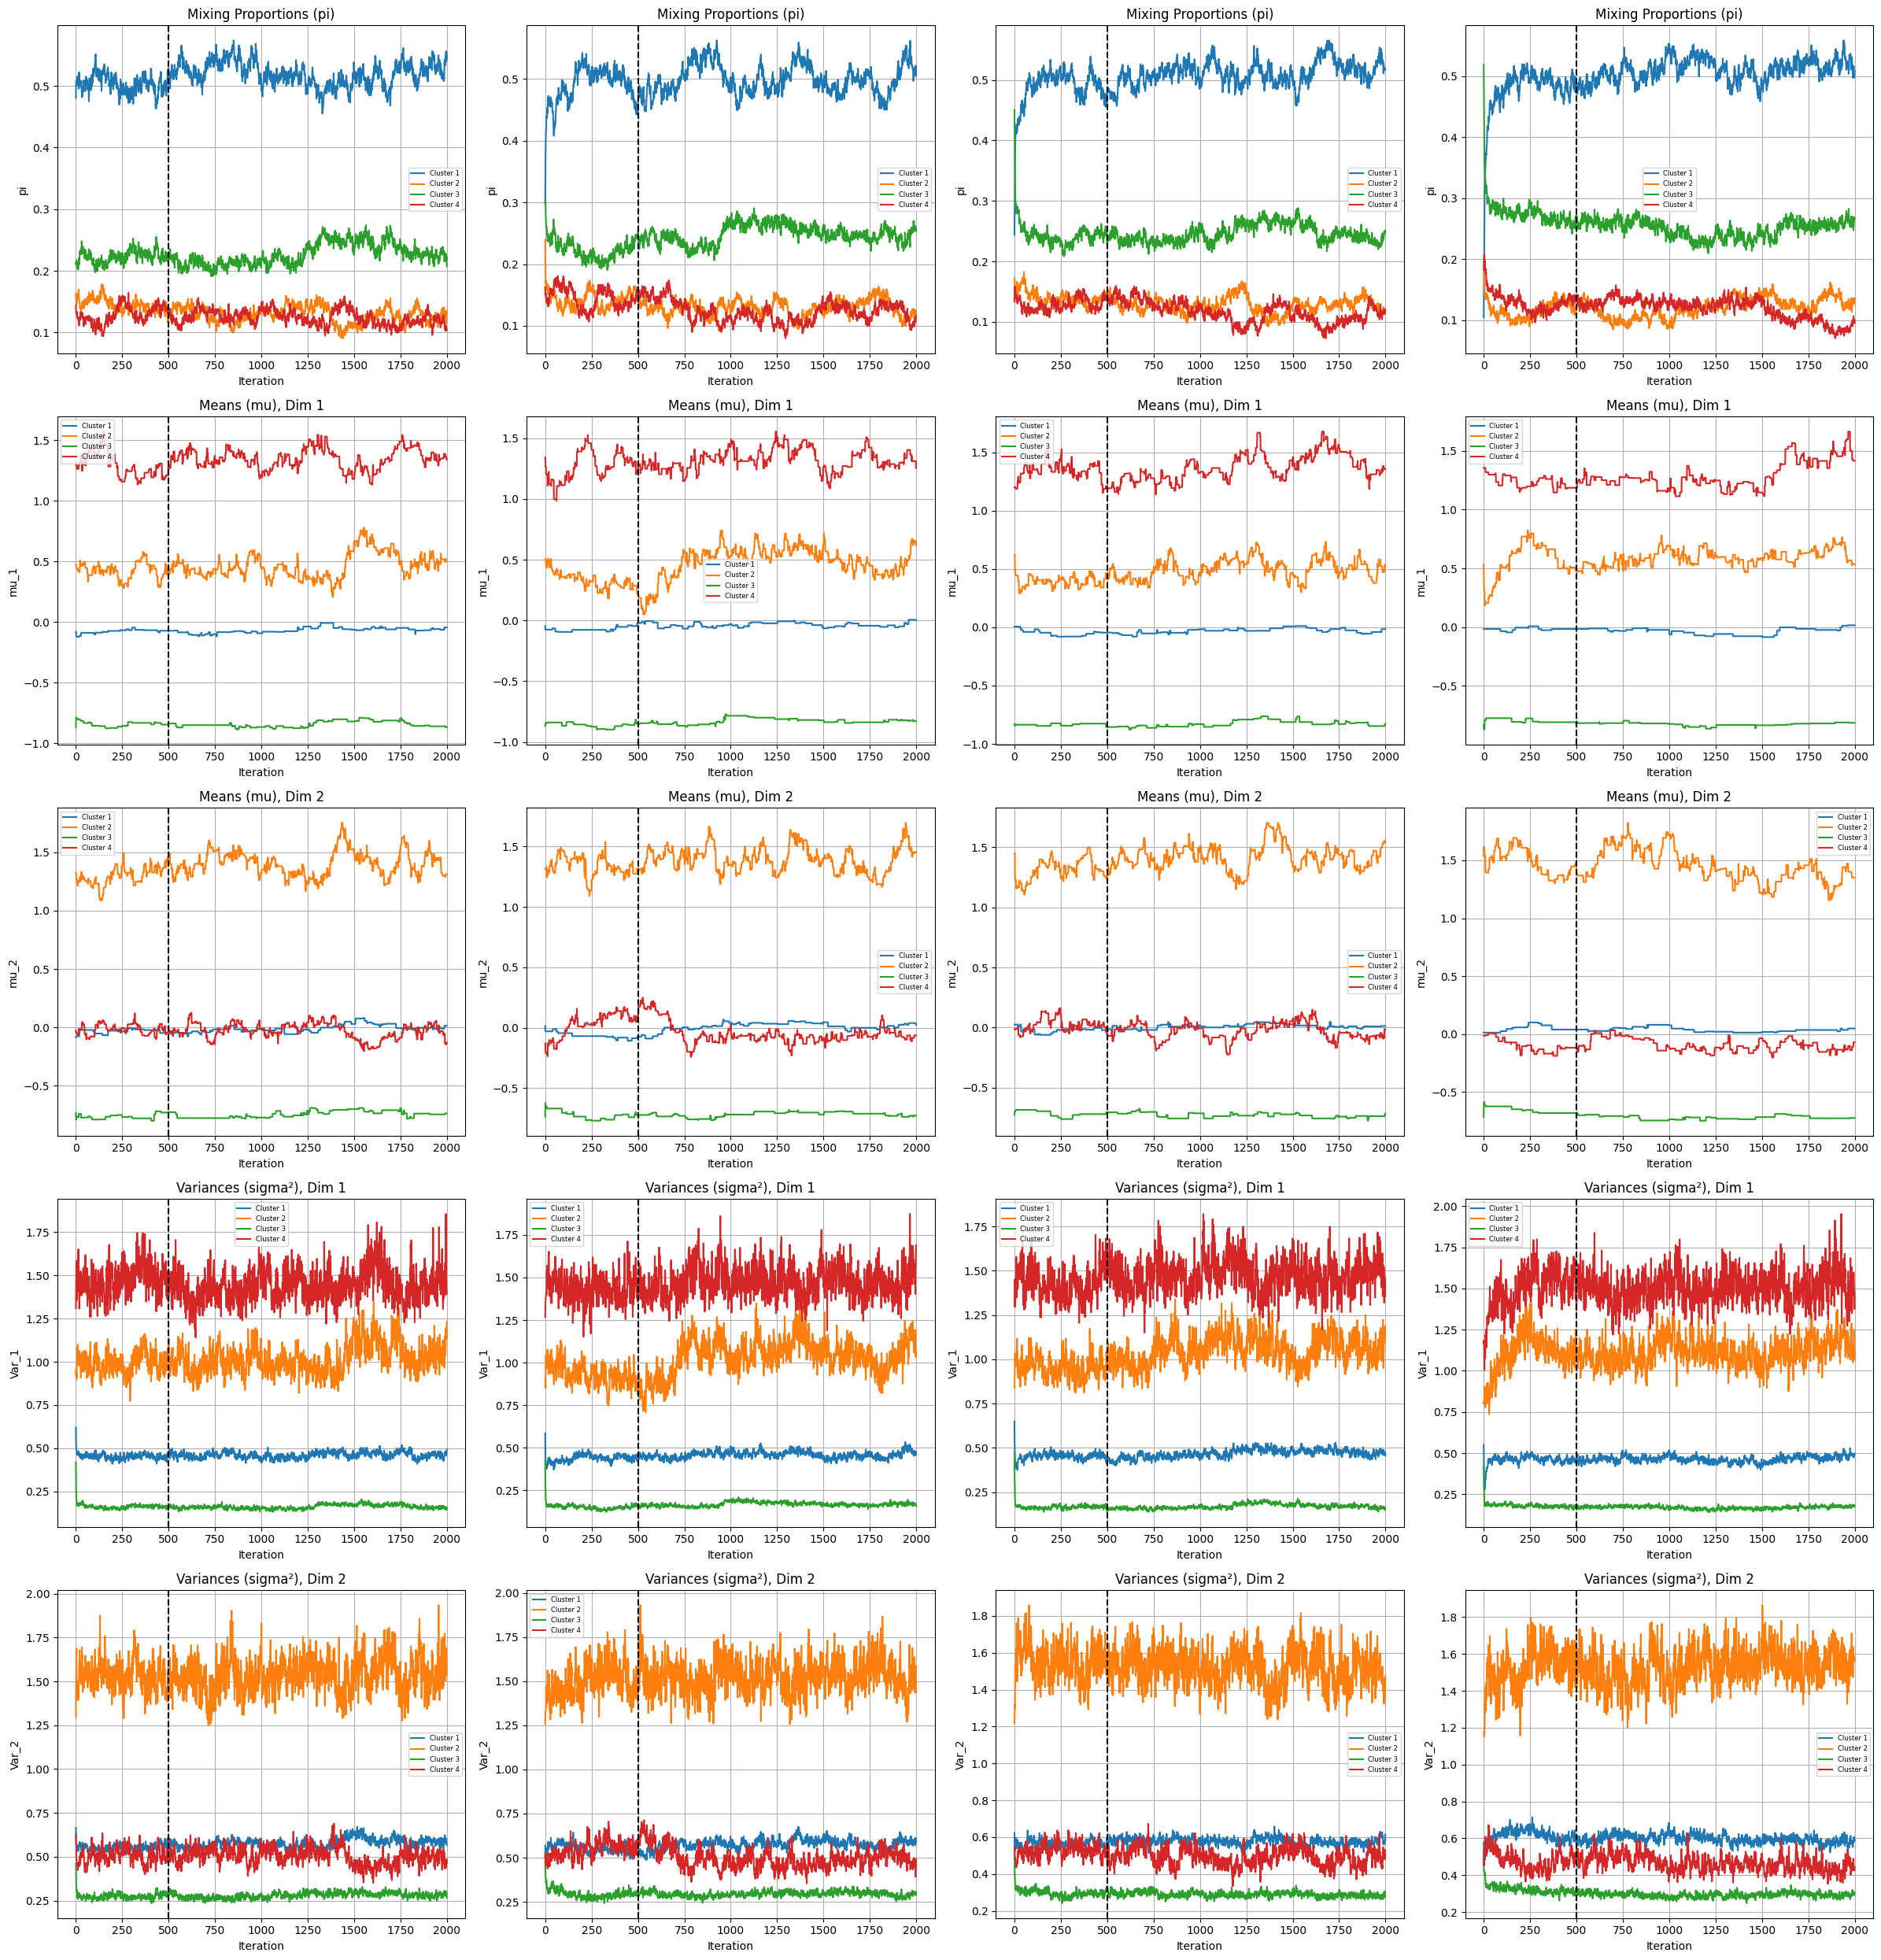

In [11]:
#set seed 42

# Parameters
# num_runs = 4
num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.06,0.065,0.07,0.1]
num_runs = len(sigma_vals)
all_run_samples = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h2, 0, sig, mu = corners)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()




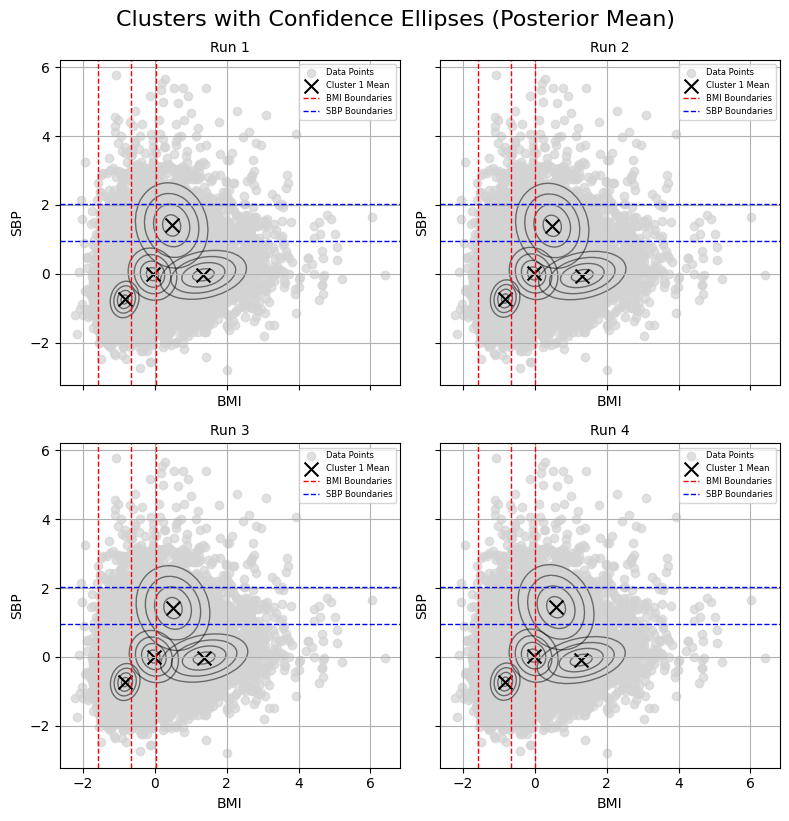

In [12]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=500)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Extract mu samples from each run: shape (num_iterations, K, p)
# For example, p = 2 (BMI and SBP)

#add burn-in to mu_samples
all_run_samples = [run[2000:] for run in all_run_samples]  # Remove burn-in samples
for run_idx, run_samples in enumerate(all_run_samples):
    mu_samples = np.array([s[1] for s in run_samples])  # shape (T, K, p)
    T, K, p = mu_samples.shape
    
    for k in range(K):
        for dim in range(p):
            plt.figure(figsize=(8, 3))
            plot_acf(mu_samples[:, k, dim], lags=60, title=f'ACF: Run {run_idx+1}, Cluster {k}, Dim {dim}', zero=False)
            plt.tight_layout()
            plt.show()

ValueError: not enough values to unpack (expected 3, got 1)

Sampling: 100%|██████████| 2000/2000 [02:02<00:00, 16.35it/s]


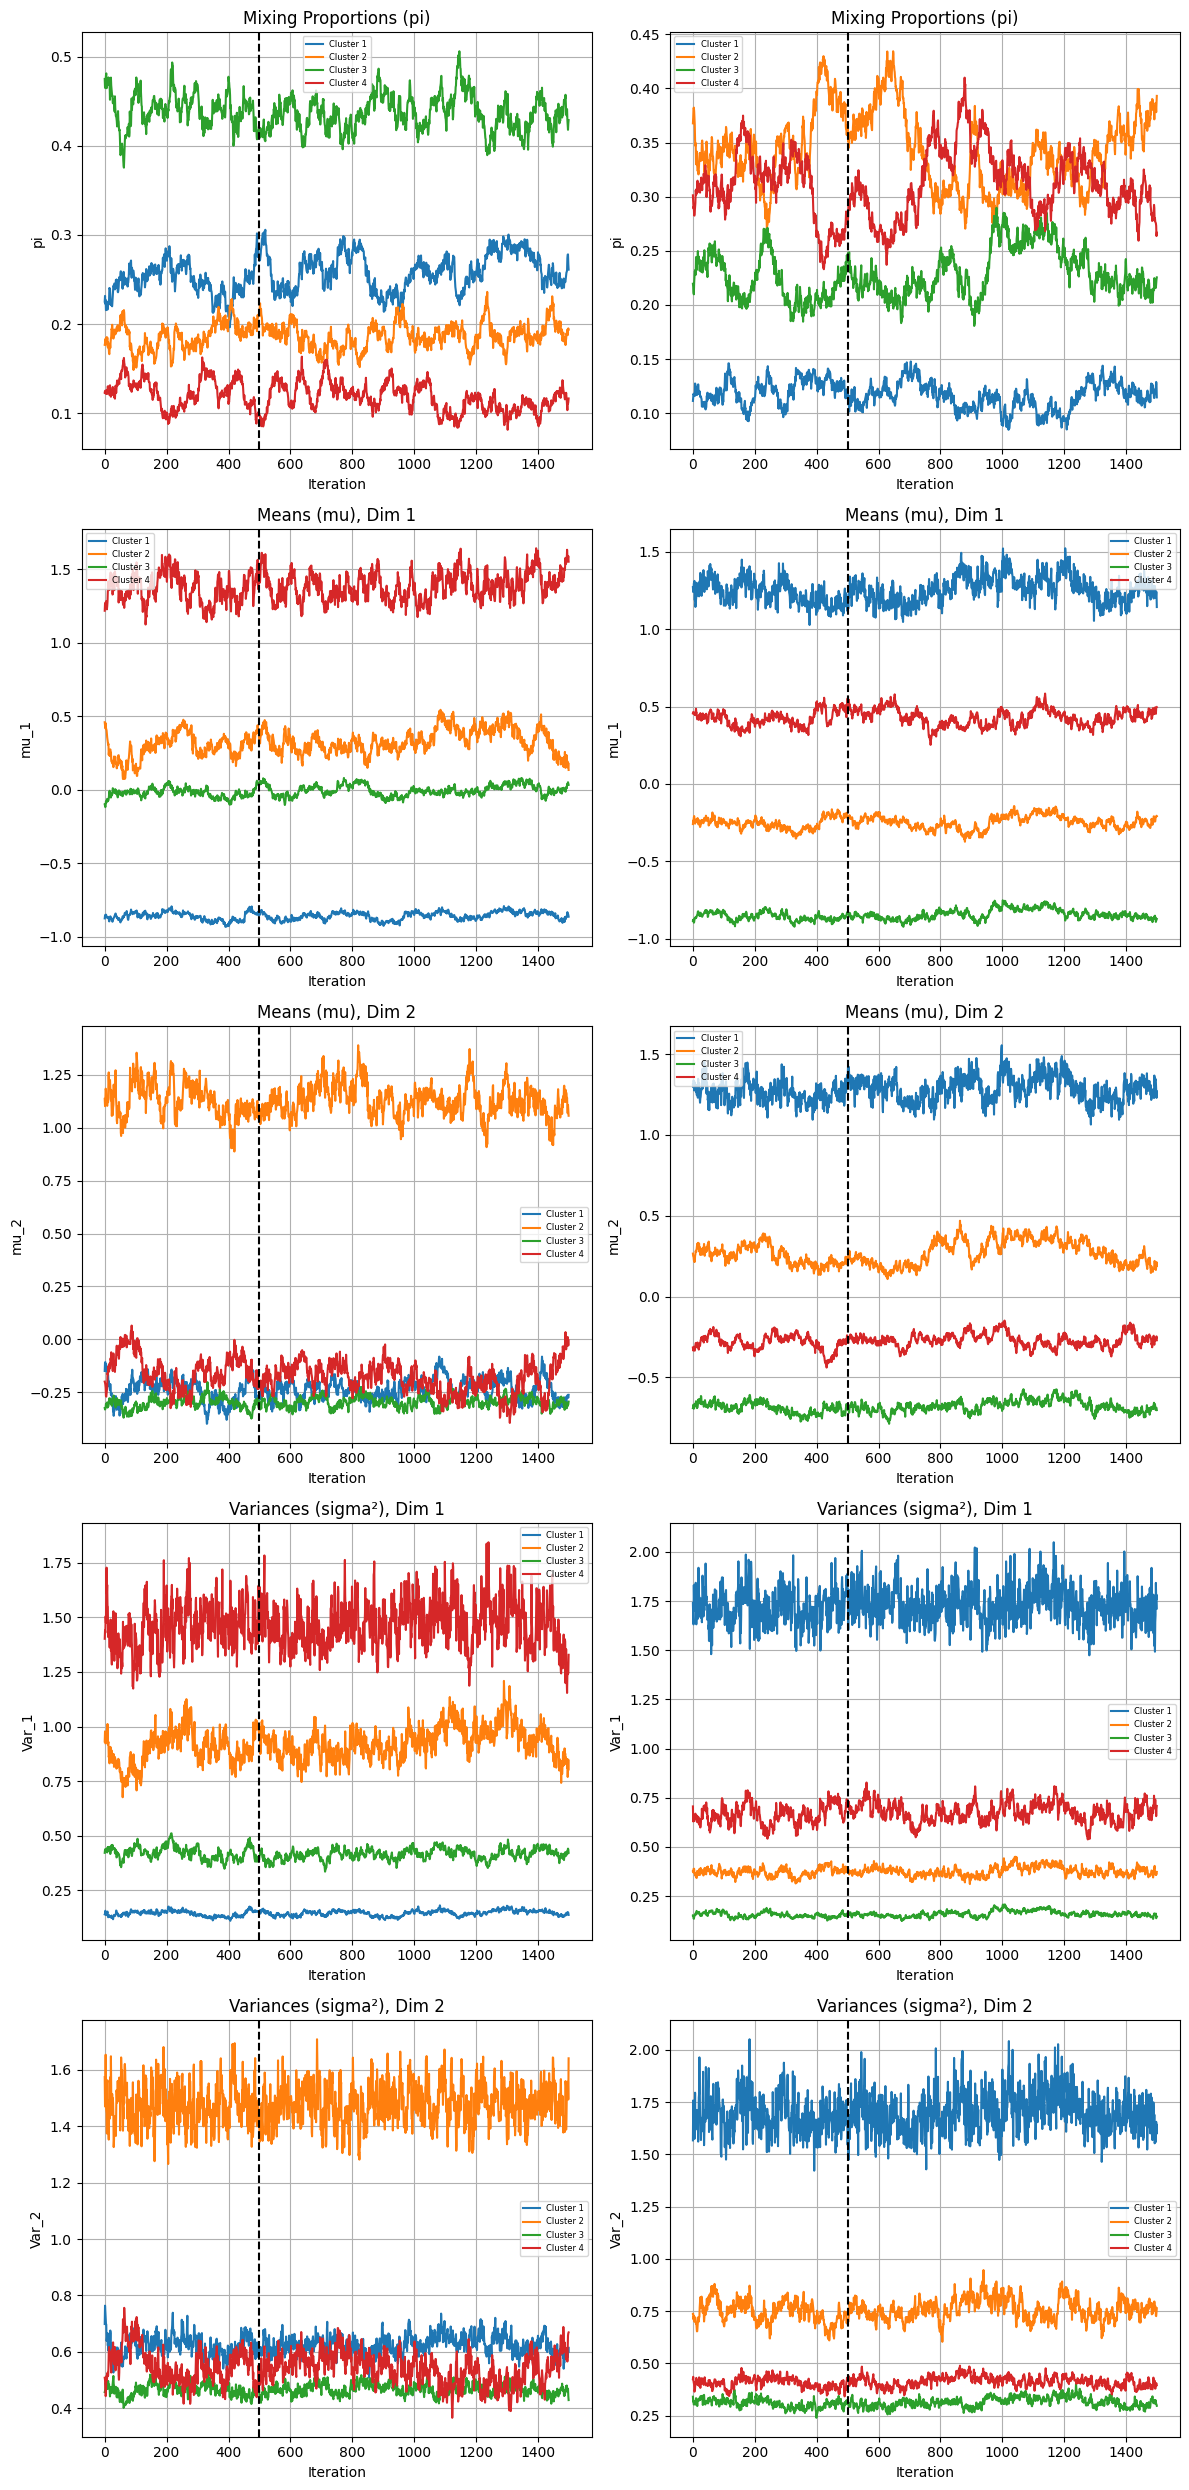

In [15]:
np.random.seed(42)
# Parameters
# num_runs = 2
num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
num_runs = 2
all_run_samples = []

for i in range(num_runs):
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, 500)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()




<Figure size 800x300 with 0 Axes>

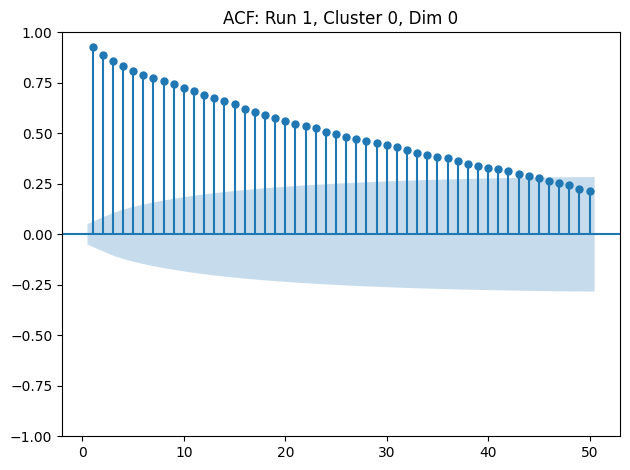

<Figure size 800x300 with 0 Axes>

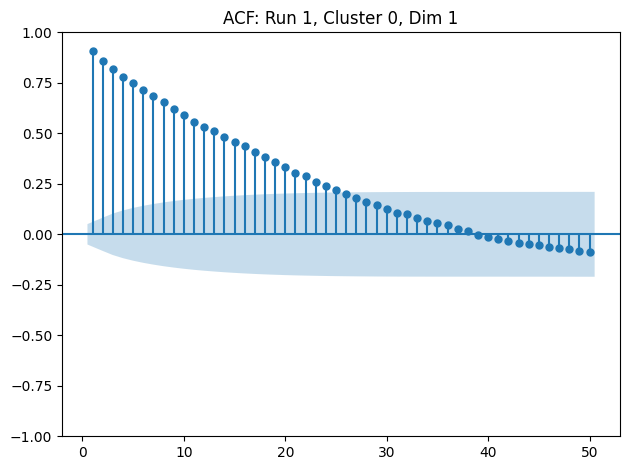

<Figure size 800x300 with 0 Axes>

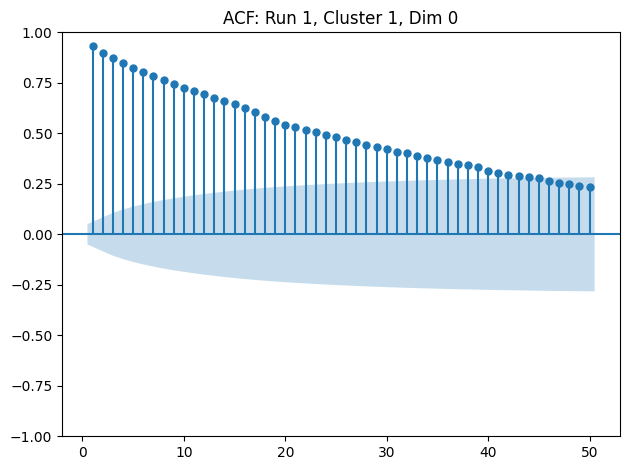

<Figure size 800x300 with 0 Axes>

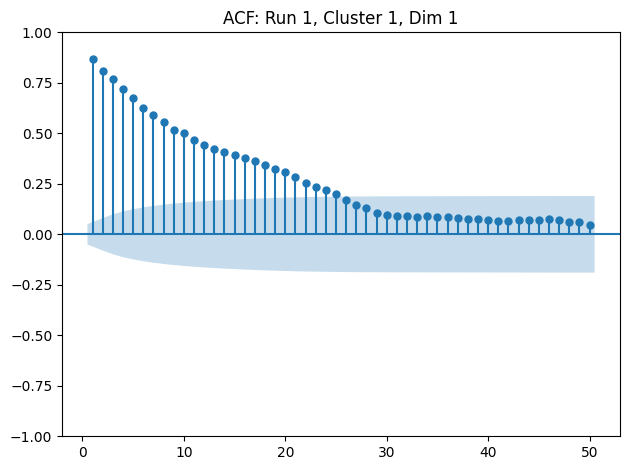

<Figure size 800x300 with 0 Axes>

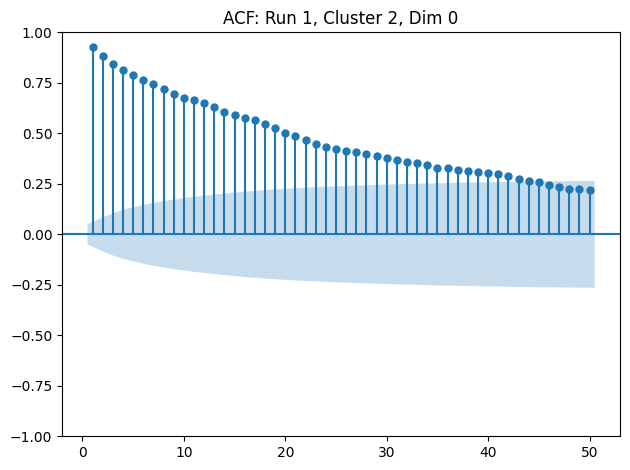

<Figure size 800x300 with 0 Axes>

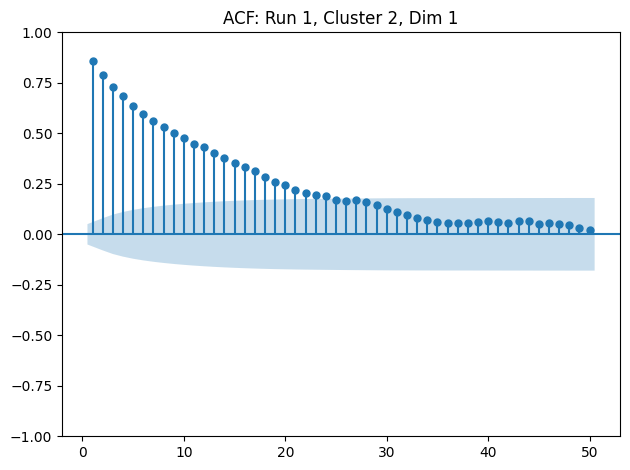

<Figure size 800x300 with 0 Axes>

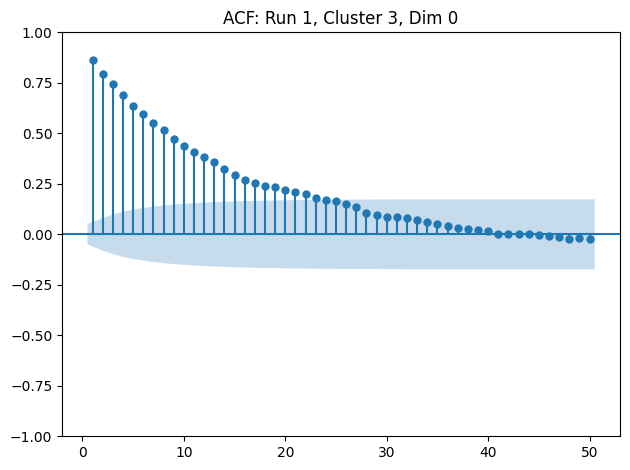

<Figure size 800x300 with 0 Axes>

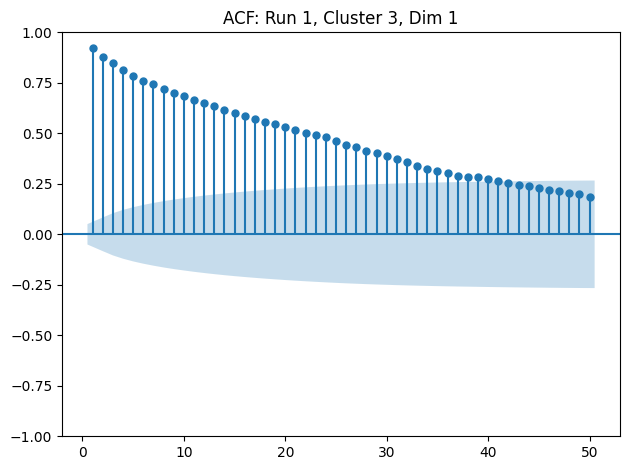

<Figure size 800x300 with 0 Axes>

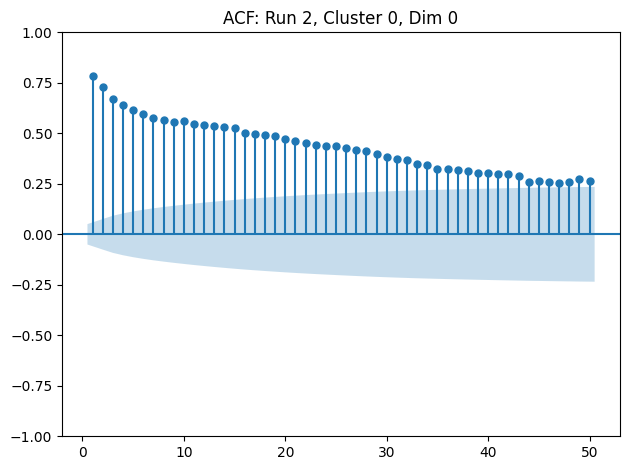

<Figure size 800x300 with 0 Axes>

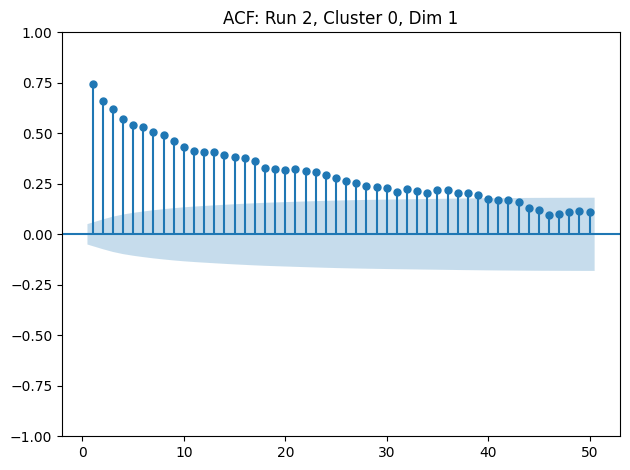

<Figure size 800x300 with 0 Axes>

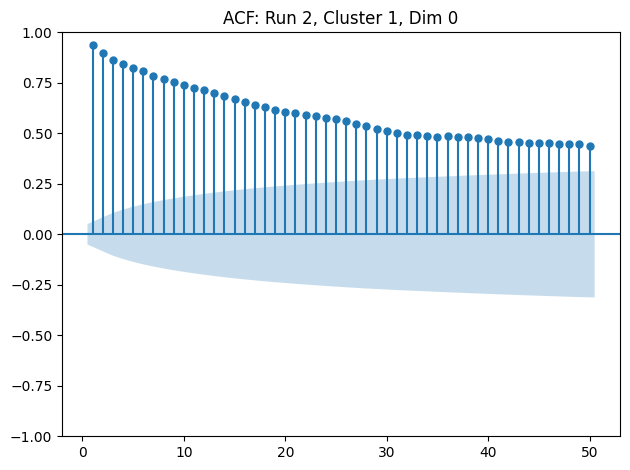

<Figure size 800x300 with 0 Axes>

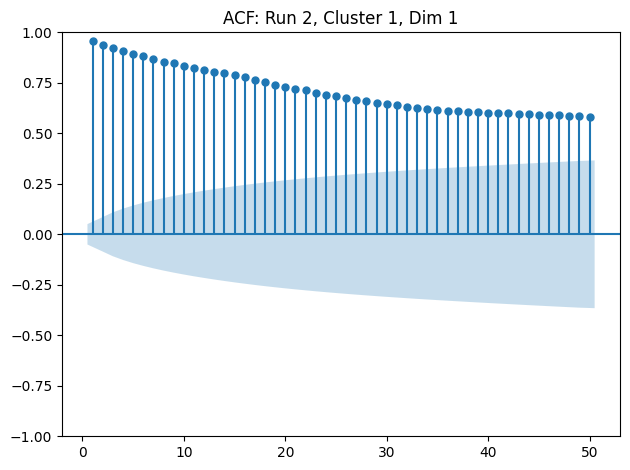

<Figure size 800x300 with 0 Axes>

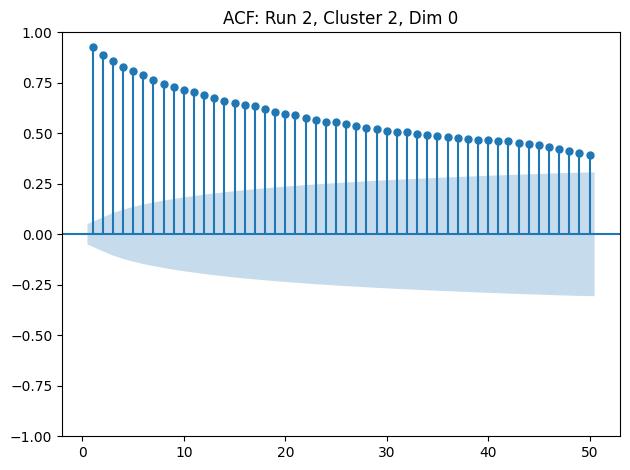

<Figure size 800x300 with 0 Axes>

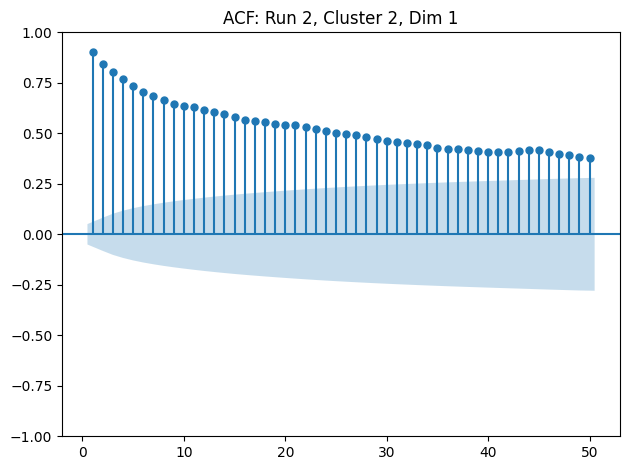

<Figure size 800x300 with 0 Axes>

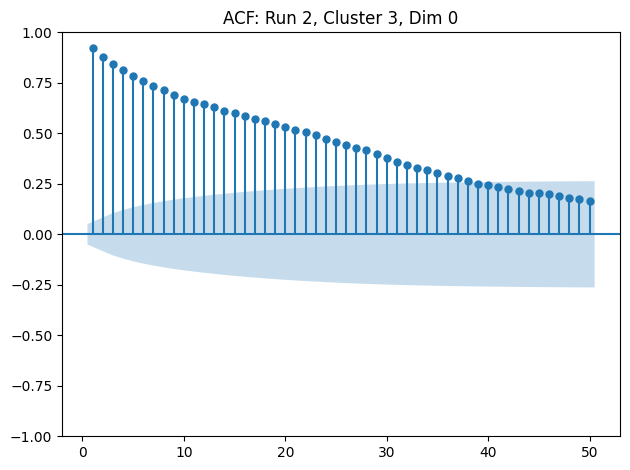

<Figure size 800x300 with 0 Axes>

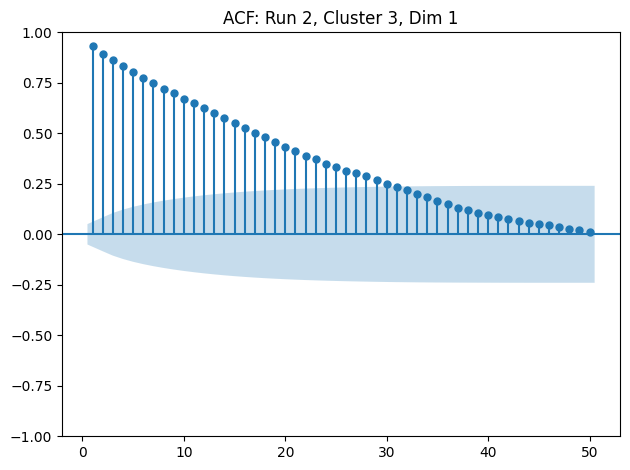

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Extract mu samples from each run: shape (num_iterations, K, p)
# For example, p = 2 (BMI and SBP)
for run_idx, run_samples in enumerate(all_run_samples):
    mu_samples = np.array([s[1] for s in run_samples])  # shape (T, K, p)
    T, K, p = mu_samples.shape
    
    for k in range(K):
        for dim in range(p):
            plt.figure(figsize=(8, 3))
            plot_acf(mu_samples[:, k, dim], lags=50, title=f'ACF: Run {run_idx+1}, Cluster {k}, Dim {dim}', zero=False)
            plt.tight_layout()
            plt.show()

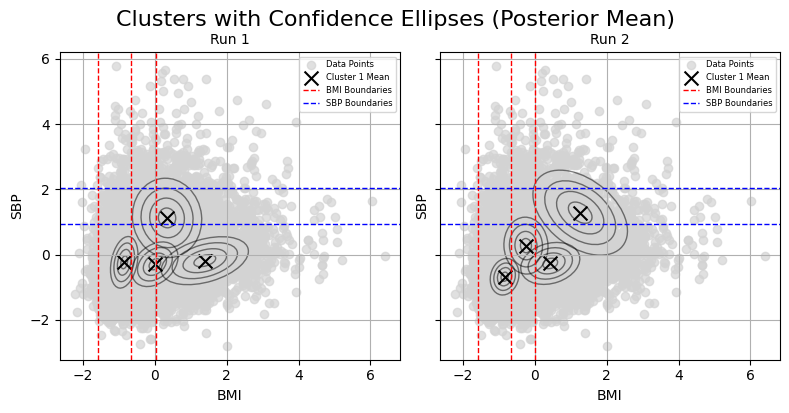

In [17]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=500)

In [ ]:
np.random.seed(42)
# Parameters
# num_runs = 4
num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.01, 0.05, 0.1, 0.15]
num_runs = len(sigma_vals)
all_run_samples = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, burn_in=500)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()




Running Gibbs Sampler for sigma = 0.01


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.25it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 2000/2000 [02:02<00:00, 16.28it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.26it/s]


Running Gibbs Sampler for sigma = 0.15


Sampling: 100%|██████████| 2000/2000 [02:02<00:00, 16.36it/s]


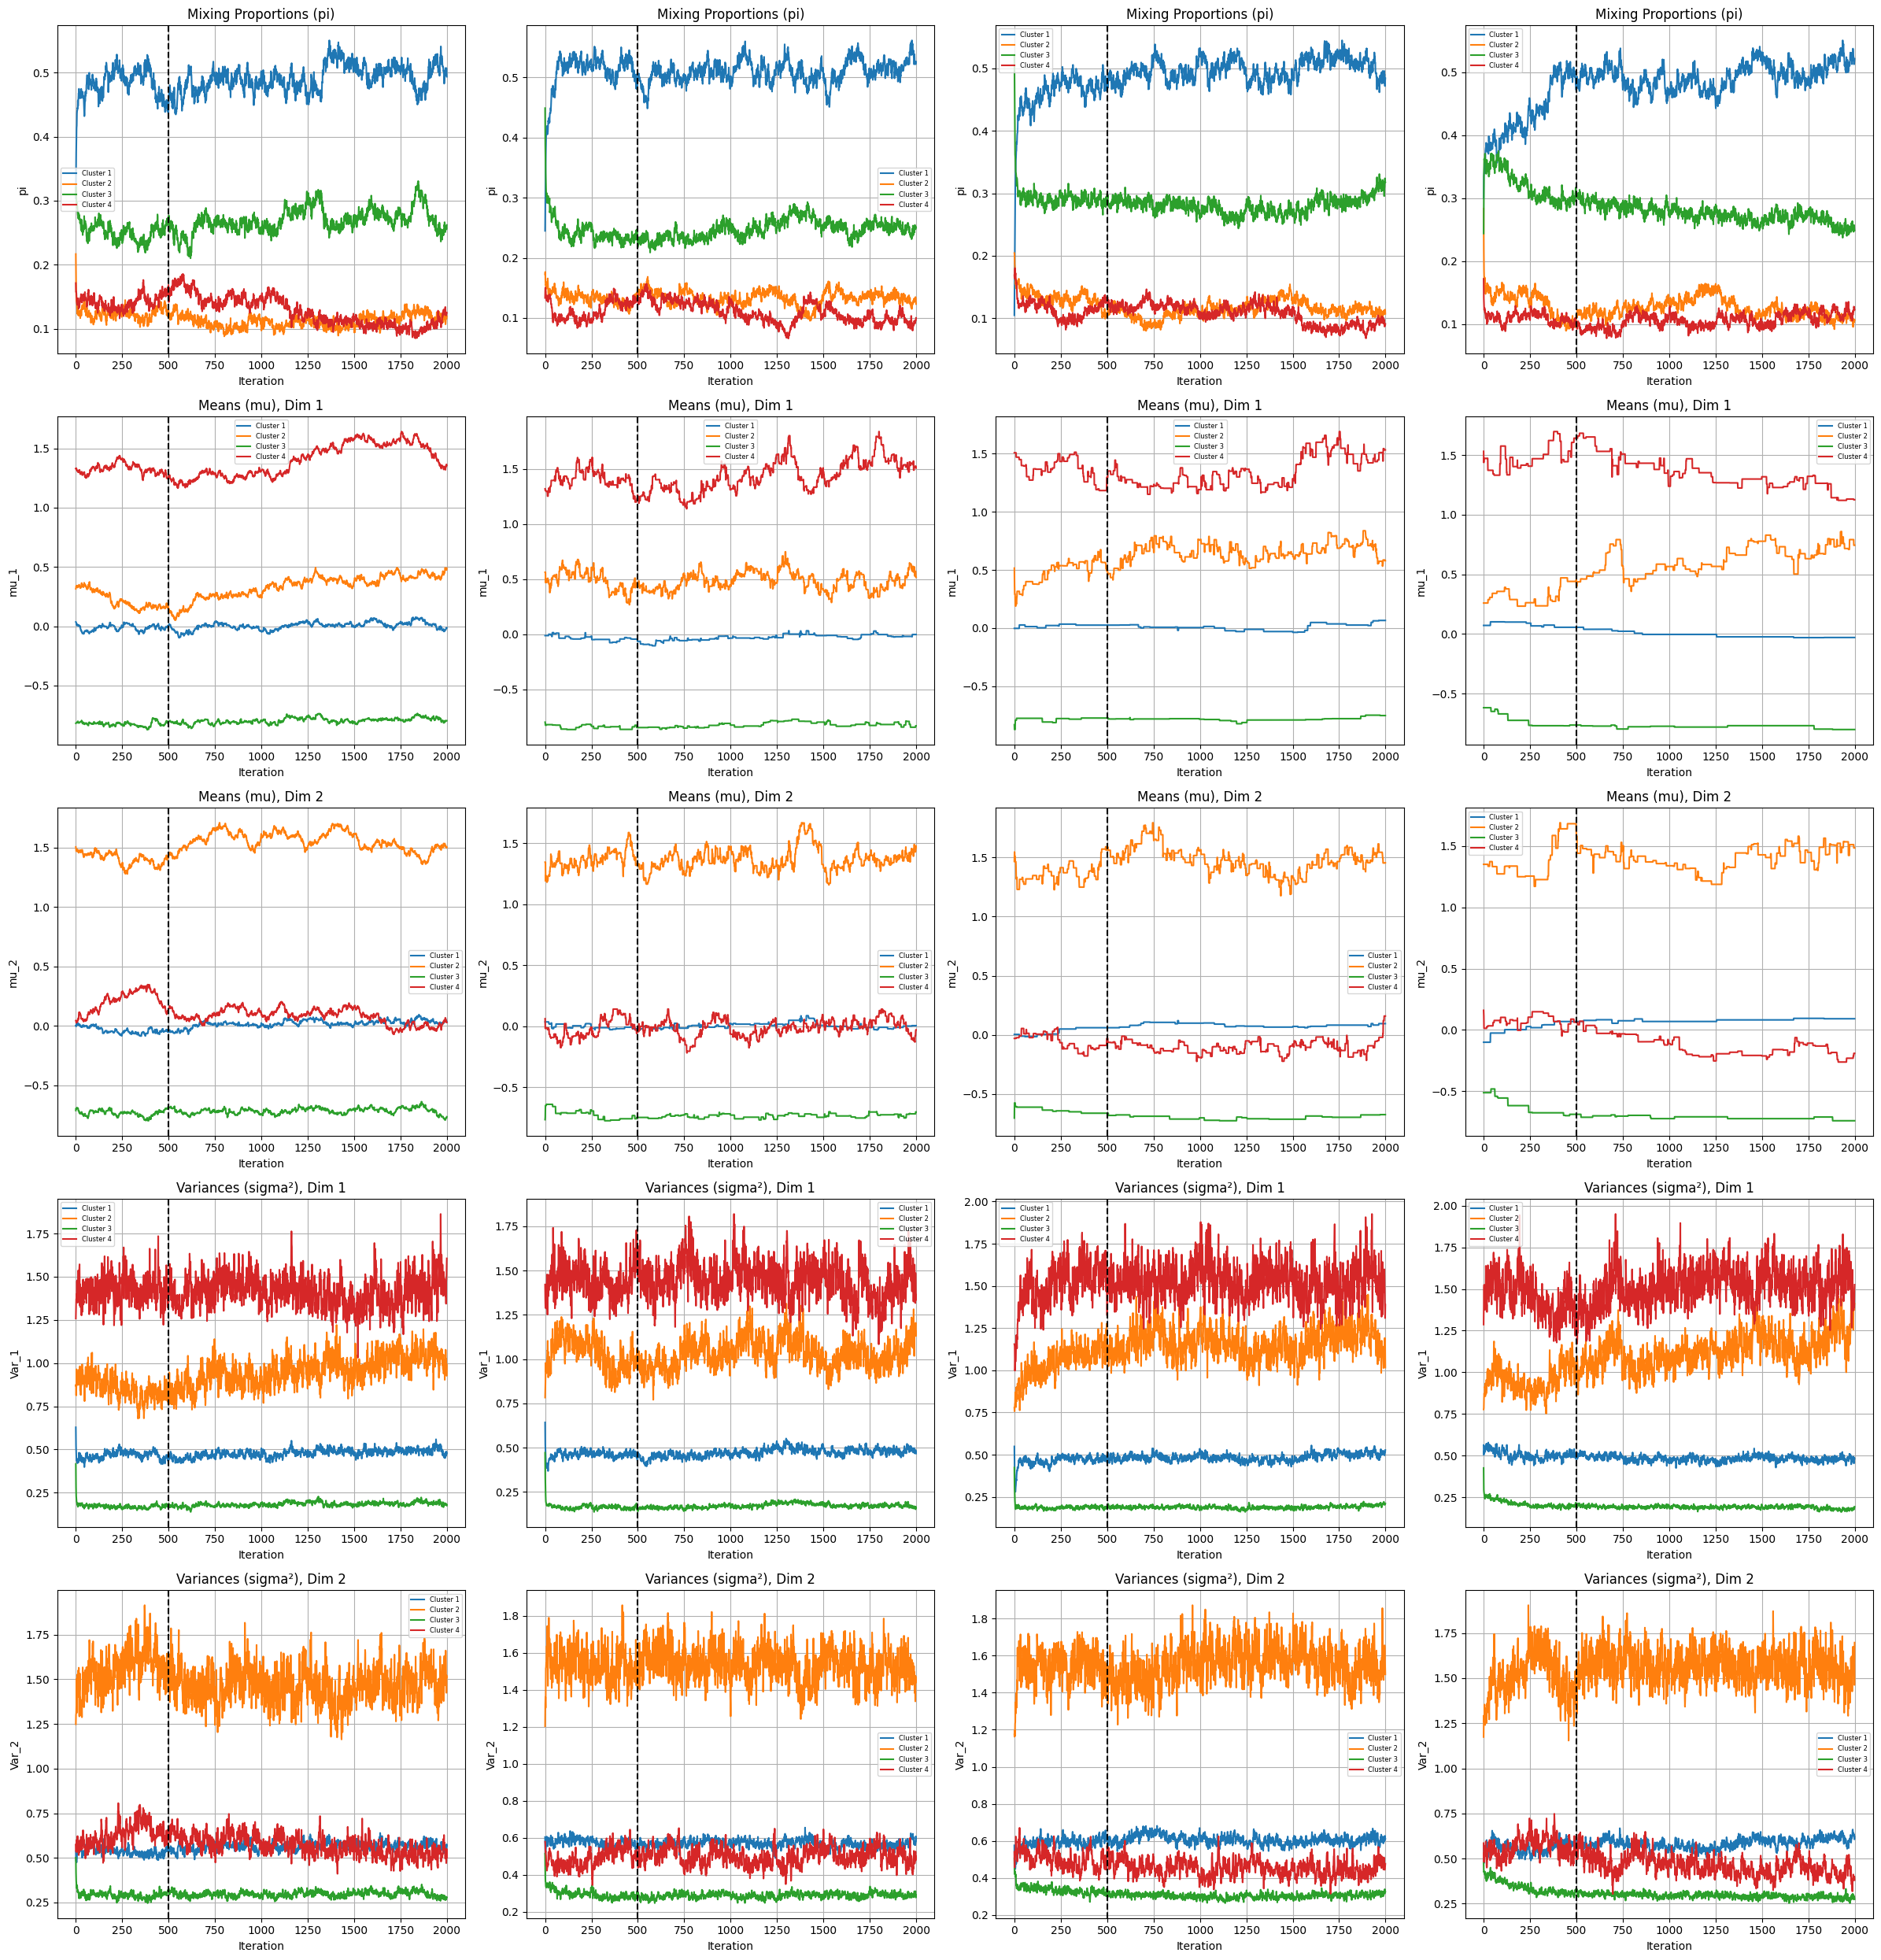

In [ ]:

num_iterations = 10000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.01, 0.05, 0.1, 0.15]
num_runs = len(sigma_vals)
all_run_samples_h1 = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h1, 0, sig, mu = corners)
    all_run_samples_h1.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples_h1[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()




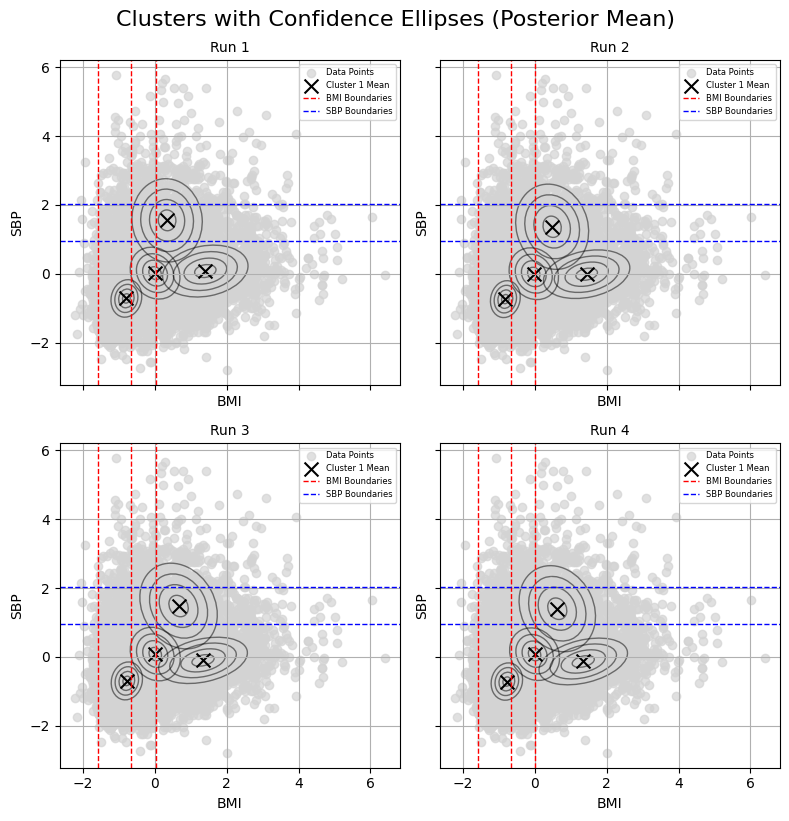

In [20]:
ellipse_mean(all_run_samples_h1, X, bmi_bounds, sbp_bounds, burn_in=500)

Running Gibbs Sampler for sigma = 0.01


Sampling: 100%|██████████| 1000/1000 [01:01<00:00, 16.28it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


Running Gibbs Sampler for sigma = 0.15


Sampling: 100%|██████████| 1000/1000 [01:01<00:00, 16.21it/s]


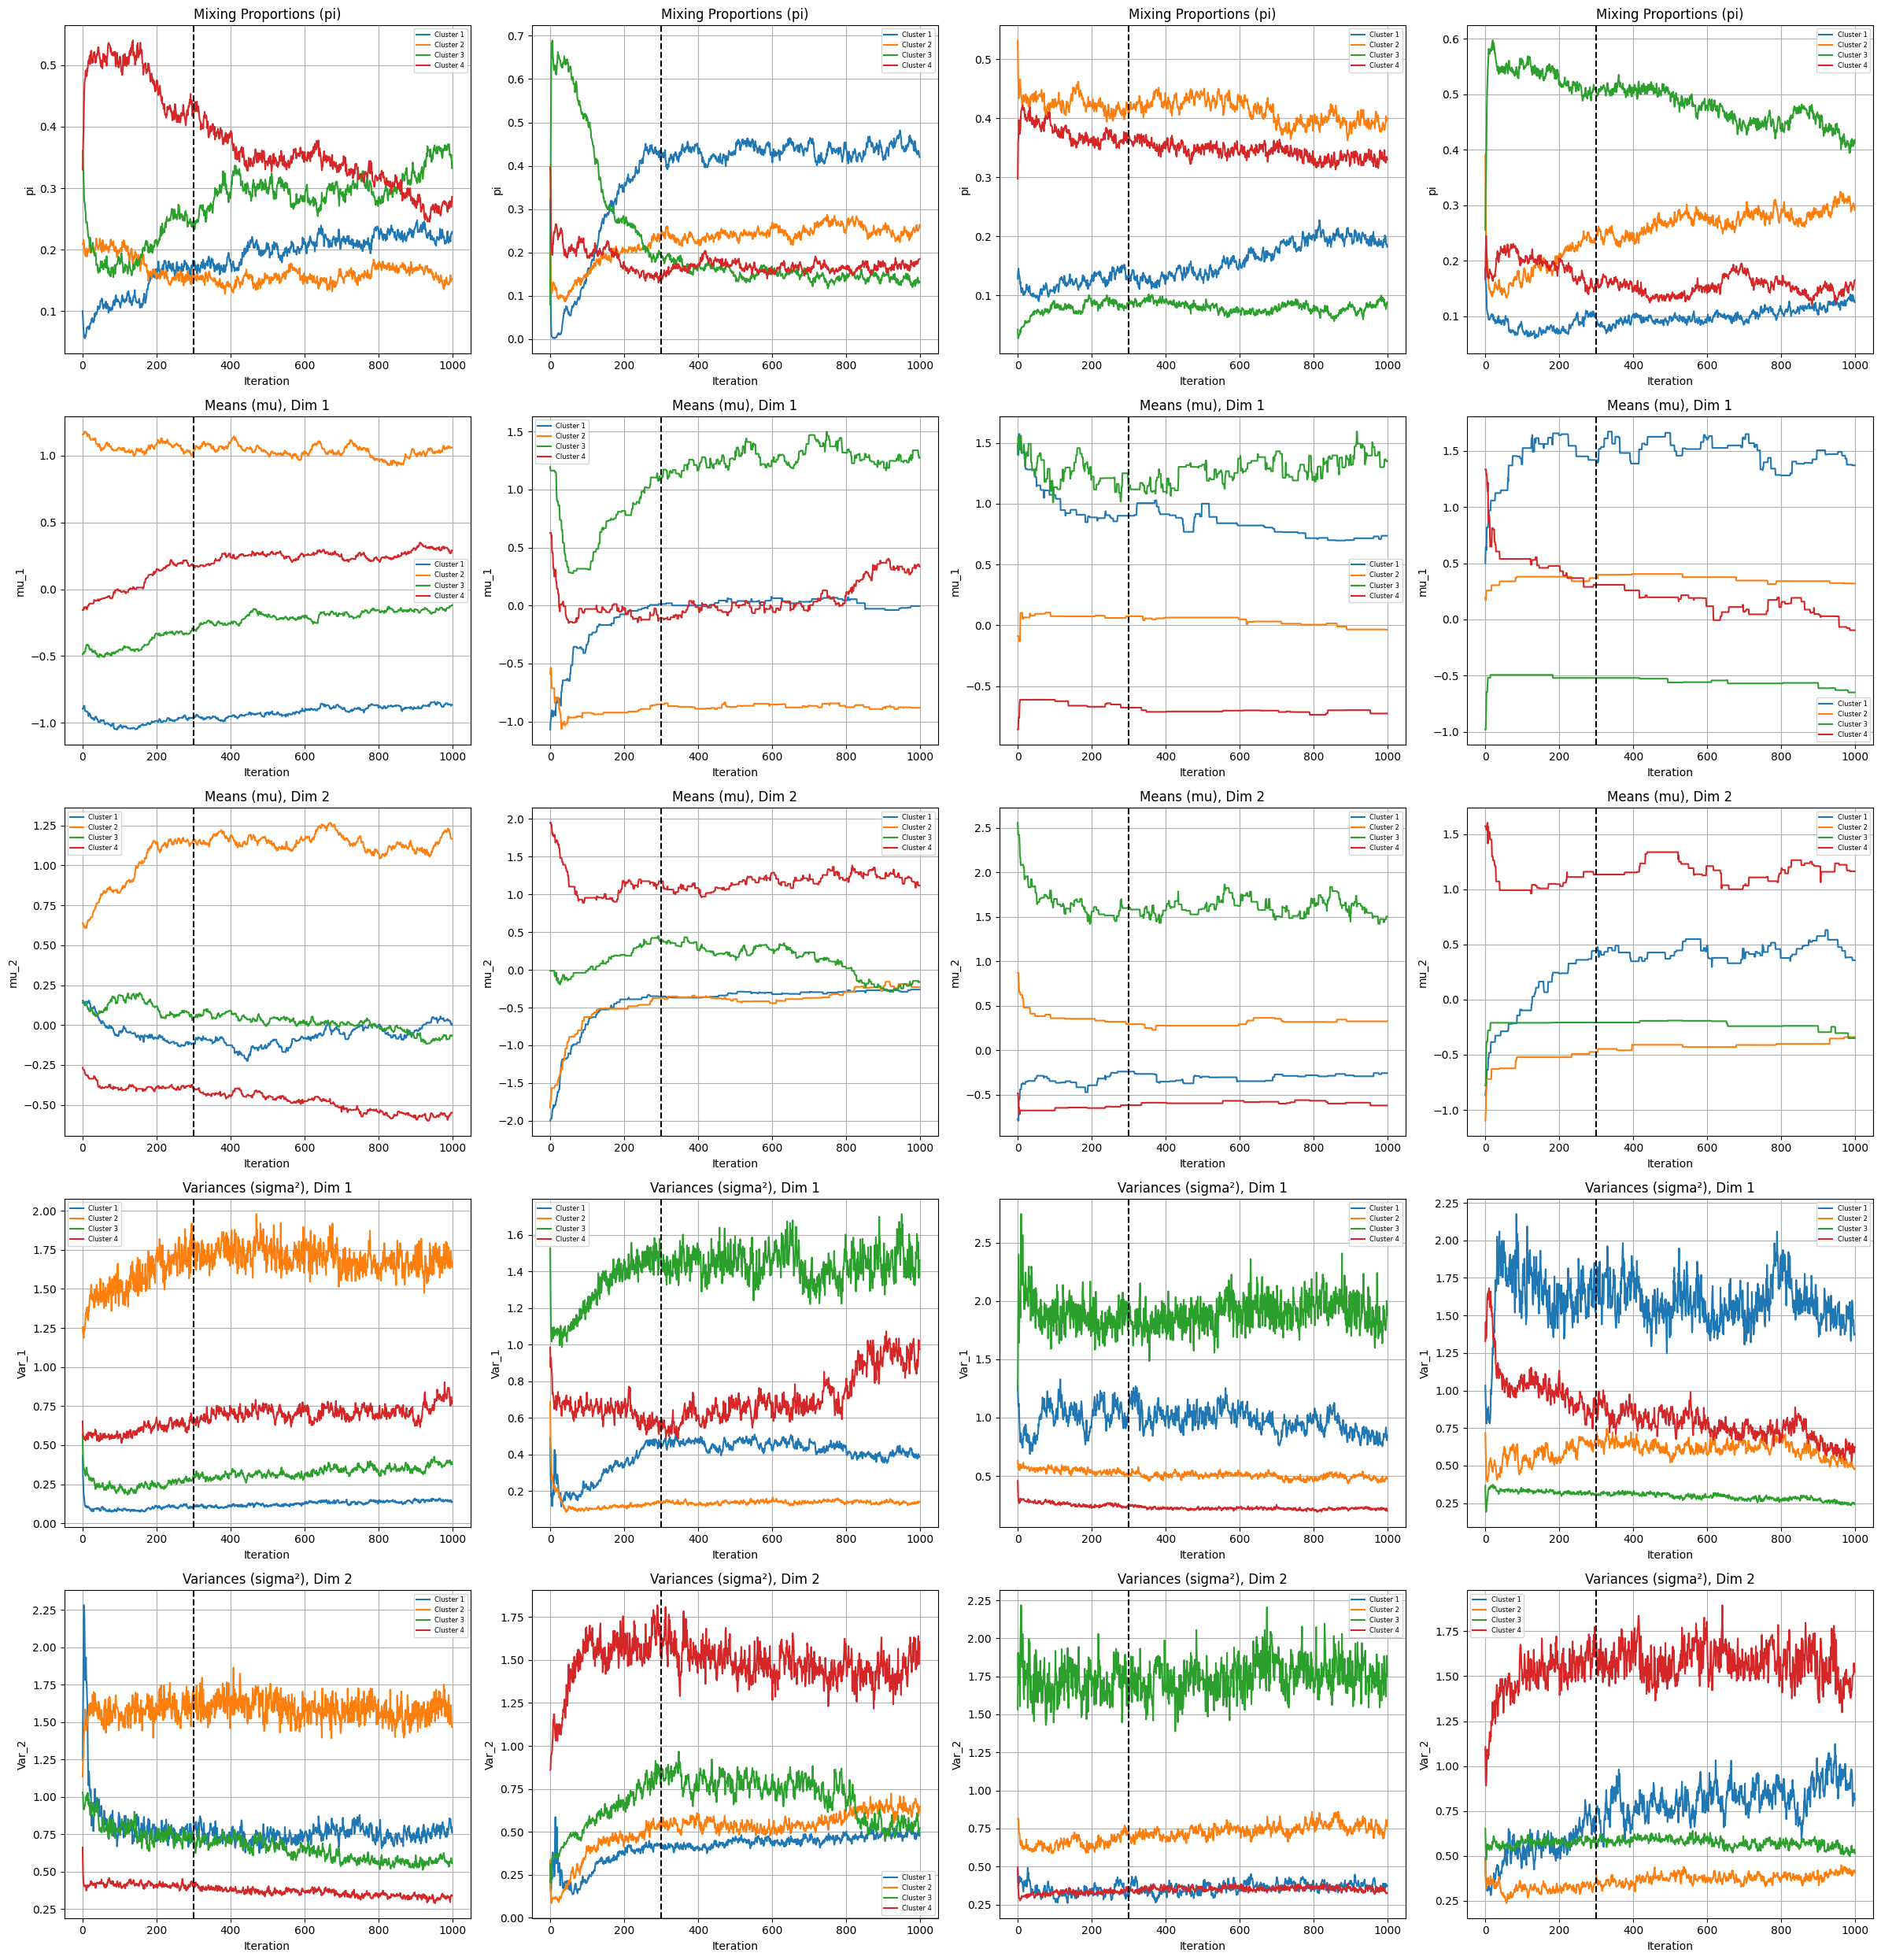

In [ ]:
num_iterations = 10000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.01, 0.05, 0.1, 0.15]
num_runs = len(sigma_vals)
all_run_samples_h11 = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk_high(X, K, num_iterations, h1, 0, sig)
    all_run_samples_h11.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples_h11[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=3000)
plt.tight_layout()
plt.show()

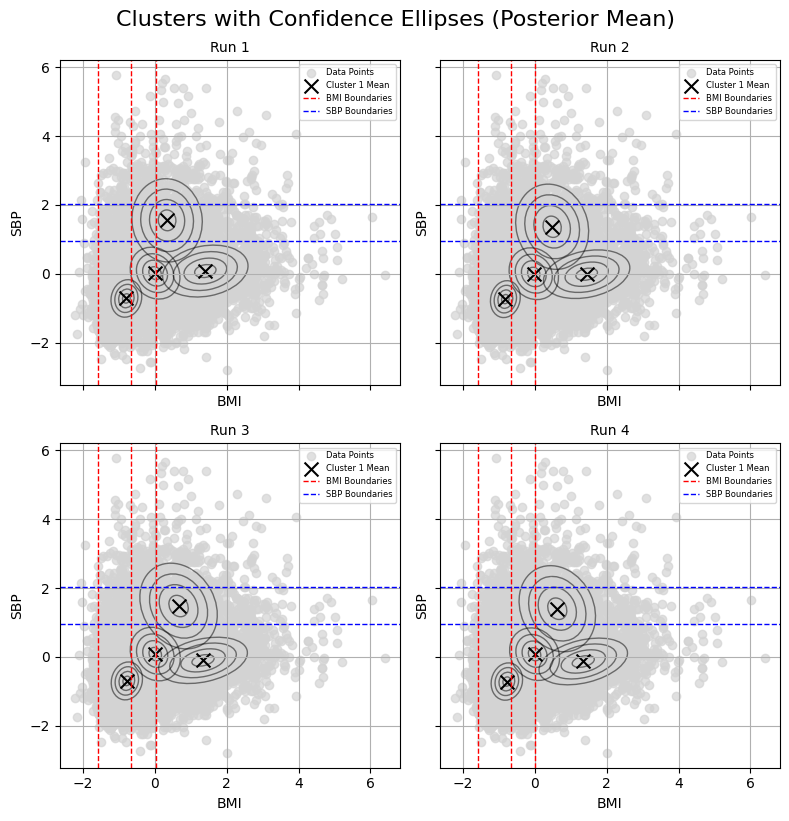

In [24]:
ellipse_mean(all_run_samples_h1, X, bmi_bounds, sbp_bounds, burn_in=500)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

def compute_distance_trace(mu_samples, mode='min'):
    """
    Computes a trace of distance statistics (min, mean, max) between cluster means.

    Parameters:
        mu_samples: ndarray of shape (T, K, p)
        mode: str, 'min', 'mean', or 'max'

    Returns:
        trace: ndarray of shape (T,)
    """
    trace = []
    for mu in mu_samples:
        dists = pdist(mu)  # All pairwise Euclidean distances between cluster means
        if mode == 'min':
            trace.append(np.min(dists))
        elif mode == 'mean':
            trace.append(np.mean(dists))
        elif mode == 'max':
            trace.append(np.max(dists))
        else:
            raise ValueError("mode must be 'min', 'mean', or 'max'")
    return np.array(trace)

# === Extract mu samples ===
mu_rep1 = np.array([s[1] for s in run_samples_rep1])     # shape: (T, K, p)
mu_norep = np.array([s[1] for s in run_samples_nonrep]) # shape: (T, K, p)
mu_rep2 = np.array([s[1] for s in run_samples_rep2])     # shape: (T, K, p)

# === Compute distance traces ===
dist_min_rep1 = compute_distance_trace(mu_rep1, mode='min')
dist_mean_rep1 = compute_distance_trace(mu_rep1, mode='mean')

dist_min_rep2 = compute_distance_trace(mu_rep2, mode='min')
dist_mean_rep2 = compute_distance_trace(mu_rep2, mode='mean')

dist_min_norep = compute_distance_trace(mu_norep, mode='min')
dist_mean_norep = compute_distance_trace(mu_norep, mode='mean')

# === Plotting ===
plt.figure(figsize=(14, 5))

# --- Minimum Distance Trace ---
plt.subplot(1, 2, 1)
plt.plot(dist_min_norep, label='No Repulsion', color='tab:blue', alpha=0.7)
plt.plot(dist_min_rep1, label='With Repulsion (h1)', color='tab:red', alpha=0.7)
plt.plot(dist_min_rep2, label='With Repulsion (h2)', color='tab:green', alpha=0.7)
plt.title('Minimum Distance Between Cluster Means')
plt.xlabel('Iteration')
plt.ylabel('Min Distance')
plt.legend()
plt.grid(True)

# --- Mean Distance Trace ---
plt.subplot(1, 2, 2)
plt.plot(dist_mean_norep, label='No Repulsion', color='tab:blue', alpha=0.7)
plt.plot(dist_mean_rep1, label='With Repulsion (h1)', color='tab:red', alpha=0.7)
plt.plot(dist_mean_rep2, label='With Repulsion (h2)', color='tab:green', alpha=0.7)
plt.title('Mean Distance Between Cluster Means')
plt.xlabel('Iteration')
plt.ylabel('Mean Distance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

def compute_ess(chain):
    """
    Compute effective sample size (ESS) for a univariate MCMC chain.
    
    Parameters:
        chain : ndarray
            1D array of samples.
            
    Returns:
        ess : float
            Effective sample size.
    """
    N = len(chain)
    chain_centered = chain - np.mean(chain)
    acf = [1.0]
    for lag in range(1, N):
        c = np.corrcoef(chain_centered[:-lag], chain_centered[lag:])[0, 1]
        if c < 0:
            break
        acf.append(c)
    return N / (1 + 2 * np.sum(acf[1:]))

# Suppose you have run your sampler and collected samples as follows:
# all_run_samples is a list of runs, each being a list of samples (pi, mu, Sigma, z)
# Let's assume you have chosen one run and applied burn-in:
# (This would typically be done after running your sampler.)
burn_in = 0
# Convert lists of samples into arrays for easy slicing:
# For example, mu_samples will have shape (T, K, p)
mu_samples = np.array([s[1] for s in all_run_samples[0][burn_in:]])
pi_samples = np.array([s[0] for s in all_run_samples[0][burn_in:]])


# You can loop over clusters and dimensions to compute ESS for all parameters.
for k in range(pi_samples.shape[1]):
    ess_pi = compute_ess(pi_samples[:, k])
    print(f"ESS for mixing proportions, cluster {k}: {ess_pi:.2f}")

for k in range(mu_samples.shape[1]):
    for dim in range(mu_samples.shape[2]):
        ess_mu = compute_ess(mu_samples[:, k, dim])
        print(f"ESS for cluster {k}, dimension {dim}: {ess_mu:.2f}")

In [ ]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

In [ ]:

burn_in = 1000
# Convert lists of samples into arrays for easy slicing:
# For example, mu_samples will have shape (T, K, p)
mu_samples = np.array([s[1] for s in all_run_samples[0][burn_in:]])
pi_samples = np.array([s[0] for s in all_run_samples[0][burn_in:]])


# You can loop over clusters and dimensions to compute ESS for all parameters.
for k in range(pi_samples.shape[1]):
    ess_pi = compute_ess(pi_samples[:, k])
    print(f"ESS for mixing proportions, cluster {k}: {ess_pi:.2f}")

for k in range(mu_samples.shape[1]):
    for dim in range(mu_samples.shape[2]):
        ess_mu = compute_ess(mu_samples[:, k, dim])
        print(f"ESS for cluster {k}, dimension {dim}: {ess_mu:.2f}")

In [ ]:
ellipse_lastit(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in)

In [ ]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

In [ ]:
# Compute posterior estimates using only samples after burn-in for one run
run_samples_burned = all_run_samples[0][burn_in:]
pi_samples = np.array([s[0] for s in run_samples_burned])
mu_samples = np.array([s[1] for s in run_samples_burned])
sigma_samples = np.array([s[2] for s in run_samples_burned])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
def h1(mu):
    return np.min(pdist(mu))*2

In [ ]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
def h1(mu):
    return np.min(pdist(mu))*3
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 3000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




In [ ]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)
